In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

data=pd.read_csv('AmesHousing.tsv', sep='\t')

In [17]:
def transform_features(df):
    length=len(df)
    nulls=df.isnull().sum()
    cols=nulls[nulls>length*.25].index
    df=df.drop(labels=cols, axis=1)
    df=df.drop(labels=['Yr Sold'], axis=1)
    df['years_until_remod']=df['Year Remod/Add']-df['Year Built']
    nulls=df.isnull().sum()
    cols=nulls[(nulls<length*.05) & (nulls>0)].index
    num_df=df[cols].select_dtypes(include=['int', 'float', 'double'])
    df[num_df.columns]=num_df.fillna(num_df.mode())
    
    df=df.drop(labels=['Street', 'Utilities', 'Condition 1', 'Condition 2', 
                             'Order', 'Central Air', 'Heating', 'PID', 'Roof Matl',
                            'Sale Condition', 'Sale Type', 'Functional'], axis=1)
    df['Indoors SF']=df['Total Bsmt SF']+df['Gr Liv Area']
    df['porch_area']=df['Screen Porch']+df['3Ssn Porch']+df['Enclosed Porch']+df['Open Porch SF']
    df=df.dropna()
    return df

We dropped a lot of columns that have low variance and that are non-numeric.

In [18]:
def convert_categorical(df):
    for column in df.columns:
        vc=df[column].value_counts()
        if len(vc)<10 and (max(vc)/len(df))<.95:
            dummies=pd.get_dummies(df[column], prefix=column)
            df=pd.concat([df, dummies], axis=1)
    return df

In [20]:
def train_and_test(df,features, k):
    if k==0:
        train=df[0:1460]
        test=df[1460:]
        lr=LinearRegression()
        lr.fit(df[features], df['SalePrice'])
        predictions=lr.predict(test[features])
        mse=mean_squared_error(test['SalePrice'], predictions)
        rmse=mse**(1/2)
        return rmse
    if k==1:
        order=np.random.permutation(df.index)
        df=df.reindex(order)
        fold_one=df[0:1460]
        fold_two=df[1460:]
        l1=LinearRegression()
        l1.fit(fold_one[features], fold_one['SalePrice'])
        predict_1=l1.predict(fold_two[features])
        l2=LinearRegression()
        l2.fit(fold_two[features], fold_two['SalePrice'])
        predict_2=l2.predict(fold_one[features])
        mse_1=mean_squared_error(fold_two['SalePrice'], predict_1)
        rmse_1=mse_1**(1/2)
        mse_2=mean_squared_error(fold_one['SalePrice'], predict_2)
        rmse_2=mse_2**(1/2)
        avg_rmse=np.mean(rmse_1+rmse_2)
        return avg_rmse
    if k>1:
        kf=KFold(k, shuffle=True, random_state=1)
        lr=LinearRegression()
        mses=cross_val_score(lr, df[features], df['SalePrice'], scoring='neg_mean_squared_error',
        cv=kf)
        rmses=np.sqrt(np.absolute(mses))
        avg_rmse=np.mean(rmses)
        return avg_rmse
        

In [21]:
pd.set_option('display.max_columns',500)
transform_data=transform_features(data)

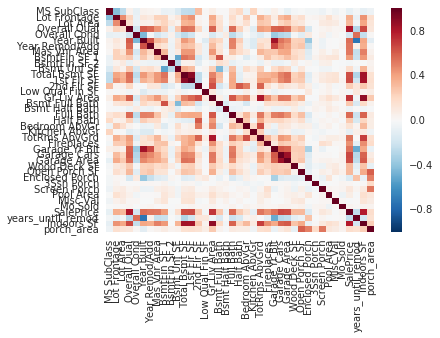

In [27]:
import seaborn as sns

num_train=transform_data.select_dtypes(include=['int', 'float', 'double'])
corrs=num_train.corr()
saleprice_corrs=corrs['SalePrice']
sns.heatmap(corrs)

In [28]:
saleprice_corrs.sort_values(ascending=False)

SalePrice            1.000000
Overall Qual         0.803153
Indoors SF           0.792386
Gr Liv Area          0.717469
Garage Cars          0.666589
Garage Area          0.651103
1st Flr SF           0.649510
Total Bsmt SF        0.648084
Full Bath            0.567360
Year Built           0.557264
Garage Yr Blt        0.539305
Year Remod/Add       0.535272
TotRms AbvGrd        0.533801
Mas Vnr Area         0.525153
Fireplaces           0.458617
BsmtFin SF 1         0.425338
Lot Frontage         0.362810
Open Porch SF        0.327231
Wood Deck SF         0.325869
Lot Area             0.321952
Bsmt Full Bath       0.270874
Half Bath            0.265087
2nd Flr SF           0.246508
Bsmt Unf SF          0.176815
porch_area           0.176756
Bedroom AbvGr        0.144602
Screen Porch         0.110068
Pool Area            0.075494
Mo Sold              0.031348
3Ssn Porch           0.016291
Misc Val            -0.014373
BsmtFin SF 2        -0.024354
Low Qual Fin SF     -0.024987
Bsmt Half 

In [30]:
def select_features(df):
    features=['Gr Liv Area', 'Overall Qual', 'Indoors SF']
    selection=features[:]
    selection.append('SalePrice')
    return df[selection], features

In [22]:
prepared_data, features=select_features(transform_data)

['Gr Liv Area', 'Overall Qual', 'Indoors SF']


In [32]:
train_and_test(prepared_data, features, 101)

37386.637003615469

In [47]:
avg_rmses=dict()
for k in range(0,500,10):
    avg_rmse=train_and_test(prepared_data, features, k)
    avg_rmses[k]=avg_rmse
avg_rmses

{0: 41430.067956909093,
 10: 40497.85667031011,
 20: 39863.332207677806,
 30: 39275.165046658753,
 40: 39121.787350738952,
 50: 38572.512924197261,
 60: 38367.827510331692,
 70: 38158.861064972523,
 80: 37800.199946040877,
 90: 37403.917262662391,
 100: 37183.082508718879,
 110: 37109.56543162639,
 120: 37060.956607617503,
 130: 36832.641993600468,
 140: 36501.109199247519,
 150: 36524.50173046795,
 160: 36288.964933543888,
 170: 36209.611991883947,
 180: 36001.07223991827,
 190: 35738.443875987366,
 200: 35718.059249633712,
 210: 35593.984077235647,
 220: 35577.498513873201,
 230: 35471.797274891775,
 240: 35500.314951464861,
 250: 35165.950399243025,
 260: 35014.94391421543,
 270: 34987.05394590371,
 280: 34991.212014188095,
 290: 34771.232866606282,
 300: 34726.298917599073,
 310: 34694.519244802512,
 320: 34598.349720140031,
 330: 34400.661669130597,
 340: 34403.03973468185,
 350: 34263.662096047286,
 360: 34302.015744062257,
 370: 34210.173049972473,
 380: 34021.923362846646,
 390

490

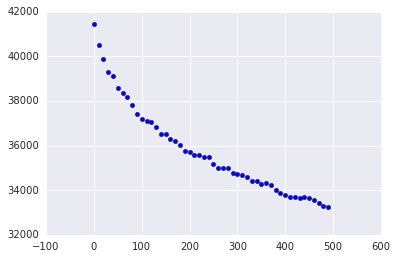

In [48]:
x=np.arange(100)
plt.scatter(list(avg_rmses.keys()), list(avg_rmses.values()))
min(avg_rmses, key=avg_rmses.get)

The avg rmse keeps getting lower with higher K values. Somewhere there has to be a point where that doesn't happen.

In [24]:
convert_categorical(transform_data)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Lot Config,Land Slope,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,SalePrice,years_until_remod,Indoors SF,porch_area,MS Zoning_C (all),MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Overall Qual_2,Overall Qual_3,Overall Qual_4,Overall Qual_5,Overall Qual_6,Overall Qual_7,Overall Qual_8,Overall Qual_9,Overall Qual_10,Overall Cond_1,Overall Cond_2,Overall Cond_3,Overall Cond_4,Overall Cond_5,Overall Cond_6,Overall Cond_7,Overall Cond_8,Overall Cond_9,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA,Bsmt Cond_Ex,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_Po,Bsmt Cond_TA,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Bsmt Full Bath_0.0,Bsmt Full Bath_1.0,Bsmt Full Bath_2.0,Bsmt Half Bath_0.0,Bsmt Half Bath_1.0,Bsmt Half Bath_2.0,Full Bath_0,Full Bath_1,Full Bath_2,Full Bath_3,Full Bath_4,Half Bath_0,Half Bath_1,Half Bath_2,Bedroom AbvGr_0,Bedroom AbvGr_1,Bedroom AbvGr_2,Bedroom AbvGr_3,Bedroom AbvGr_4,Bedroom AbvGr_5,Bedroom AbvGr_6,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Cars_1.0,Garage Cars_2.0,Garage Cars_3.0,Garage Cars_4.0,Garage Cars_5.0,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,20,RL,141.0,31770,IR1,Lvl,Corner,Gtl,NAmes,1Fam,1Story,6,5,1960,1960,Hip,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,Fa,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,2,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,0,5,215000,0,2736.0,62,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,


    Continue iteration on feature engineering:
        Reserach some other approaches to feature engineering online around housing data.
        Visit the Kaggle kernels page for this dataset to see approaches others took.
    Improve your feature selection:
        Research ways of doing feature selection better with categorical columns (something we didn't cover in this particular course).
